In [2]:
import requests
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np              

#API BTC BINANCE

url = "https://api.binance.com/api/v3/klines"
params = {
    "symbol": "BTCUSDT",
    "interval": "1w",   
    "limit": 1000
}


response = requests.get(url, params=params)
data = response.json()

btc = pd.DataFrame(data, columns=[
    "open_time", "open", "high", "low", "close", "volume",
    "close_time", "quote_asset_volume", "number_of_trades",
    "taker_base_vol", "taker_quote_vol", "ignored"
])


btc["open_time"] = pd.to_datetime(btc["open_time"], unit="ms")
btc["close_time"] = pd.to_datetime(btc["close_time"], unit="ms")

cols_float=["open","close", "high", "low", "volume", "quote_asset_volume", "taker_base_vol", "taker_quote_vol", "ignored"]

for c in cols_float:
    btc[c]=btc[c].astype(float)


In [3]:
oro=pd.read_csv("datos originales/oro.csv")
oro = oro.drop(columns=['Unnamed: 4', 'Unnamed: 8'])
oro = oro.rename(columns={
    'Date': 'open_time',
    'High (kg)': 'high_kg',
    'Low (kg)': 'low_kg',
    'Close (kg)': 'close_kg',
    'High (troy oz)': 'high_oz',
    'Low (troy oz)': 'low_oz',
    'Close (troy oz)': 'close_oz'
})

oro['open_time'] = pd.to_datetime(oro['open_time'], format='%H:%M:%S %d-%b-%Y')

In [4]:
letras=pd.read_excel("datos originales/Letras del tesoro.xlsx")
letras.rename(columns={
    "Fecha de la subasta": "fecha",
    "Nominal solicitado Mill. €": "nominal_solicitado",
    "Nominal adjudicado Mill. €": "nominal_adjudicado",
    "Tipo marginal": "tipo_marginal",
    "Tipo interés medio": "interes_medio",
    "Fecha vencimiento": "fecha_vencimiento",
    "ret": "retorno"
}, inplace=True)

In [5]:
sp500=pd.read_csv("datos originales/S&P500.csv")
sp500 = sp500.rename(columns={
    'Fecha': 'open_time',
    'Apertura': 'open',
    'Máximo': 'high',
    'Mínimo': 'low',
    'Último': 'close',
    'Vol.': 'volume',
    '% var.': 'ignored'
})

sp500= sp500.drop(columns={'volume'})
# Reemplazar comas por puntos y convertir a float

sp500["open_time"]=pd.to_datetime(sp500['open_time'], format="%d.%m.%Y")

cols = ["close", "open", "high", "low"] 

for col in cols:
    
    sp500[col] = sp500[col].str.replace(".", "", regex=False)
    sp500[col] = sp500[col].str.replace(",", ".", regex=False)
    
    sp500[col] = sp500[col].astype(float)


CONEXION SQL


In [6]:
!pip install python-dotenv sqlalchemy pymysql pandas


from dotenv import load_dotenv
import os
from sqlalchemy import create_engine


load_dotenv()

user = os.getenv("MYSQL_USER")
password = os.getenv("MYSQL_PASSWORD")
db = os.getenv("MYSQL_DB")
host = os.getenv("MYSQL_HOST")


print("USER:", user)
print("PASSWORD:", "*"*len(password)) 
print("DB:", db)
print("HOST:", host)


engine = create_engine(f"mysql+pymysql://{user}:{password}@{host}/{db}")


btc.to_sql("btc", engine, if_exists="replace", index=False)
sp500.to_sql("sp500", engine, if_exists="replace", index=False)
oro.to_sql("oro", engine, if_exists="replace", index=False)
letras.to_sql("letras_del_tesoro", engine, if_exists="replace", index=False)

print("Todos los datasets se han subido correctamente a la base de datos 'finanzas'.")


USER: root
PASSWORD: ********
DB: finanzas
HOST: localhost
Todos los datasets se han subido correctamente a la base de datos 'finanzas'.


## IPC

In [7]:
import pandas as pd

ipc = pd.read_excel("datos originales/IPC.xlsx", skiprows=1)
ipc= ipc[["Periodo", "Total"]]

ipc["Total"]=ipc["Total"].astype(float)



In [8]:
ipc["Periodo"]= pd.to_datetime(ipc["Periodo"], format="%YM%m")

In [9]:
import plotly.express as px
import pandas as pd

fig = px.line(
    ipc,
    x="Periodo",
    y="Total",
    markers=True,
    title="Evolución del IPC",
    labels={"Total": "IPC Total", "Periodo": "Periodo"}
)

fig.update_layout(
    xaxis_title="Periodo",
    yaxis_title="IPC Total",
    hovermode="x unified",
    template="plotly_white"
)

fig.show()

In [10]:
ipc['año']=ipc['Periodo'].dt.year
ipc_ultimo_mes= ipc.sort_values('Periodo').groupby(ipc['Periodo'].dt.year).tail(1)
ipc_ultimo_mes['variación_%'] = ipc_ultimo_mes['Total'].pct_change() * 100
incremento_medio_anual= ipc_ultimo_mes['variación_%'].mean()
print(f"Incremento medio anual: {incremento_medio_anual:}%")

Incremento medio anual: 2.2106021060130243%


### Necesitamos al menos un 2.21% de beneficio para proteger nuestro dinero de la inflación

## Comparación de activos

In [11]:
import plotly.express as px
import pandas as pd

btc = btc.sort_values("open_time")

btc_high = btc[["open_time", "high"]]

fig = px.line(
    btc_high,
    x="open_time",
    y="high",
    title="Evolución del precio HIGH de Bitcoin en el tiempo",
    labels={"open_time": "Fecha (open_time)", "high": "Precio HIGH"}
)

fig.update_traces(line=dict(color="orange", width=2))



fig.show()


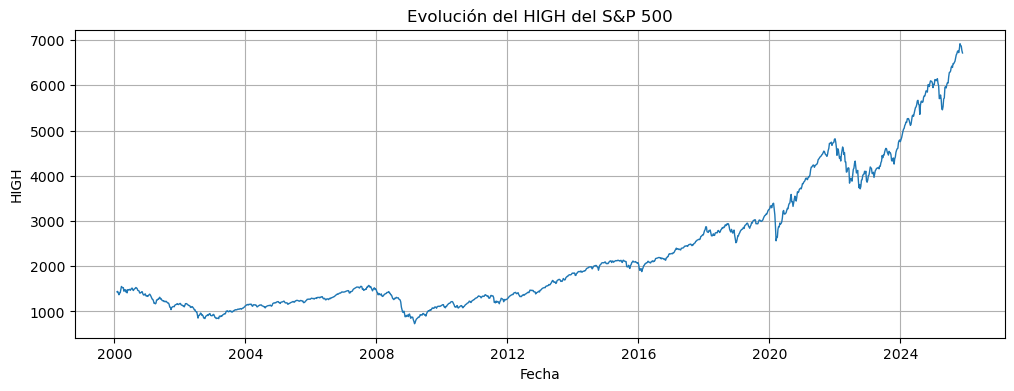

In [12]:
sp500_high = sp500.set_index("open_time")["high"]

# Gráfico
plt.figure(figsize=(12,4))
plt.plot(sp500_high.index, sp500_high.values, linewidth=1)
plt.title("Evolución del HIGH del S&P 500")
plt.xlabel("Fecha")
plt.ylabel("HIGH")
plt.grid(True)
plt.show()

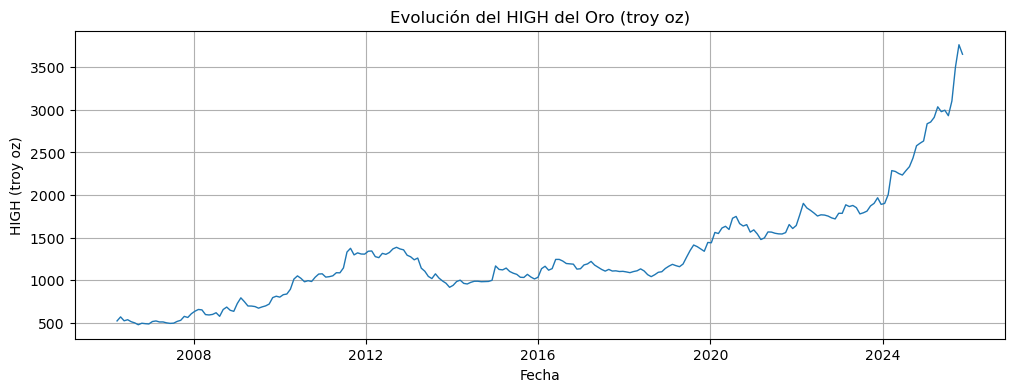

In [13]:
oro_high = oro.set_index("open_time")["high_oz"]

# Gráfico
plt.figure(figsize=(12,4))
plt.plot(oro_high.index, oro_high.values, linewidth=1)
plt.title("Evolución del HIGH del Oro (troy oz)")
plt.xlabel("Fecha")
plt.ylabel("HIGH (troy oz)")
plt.grid(True)
plt.show()

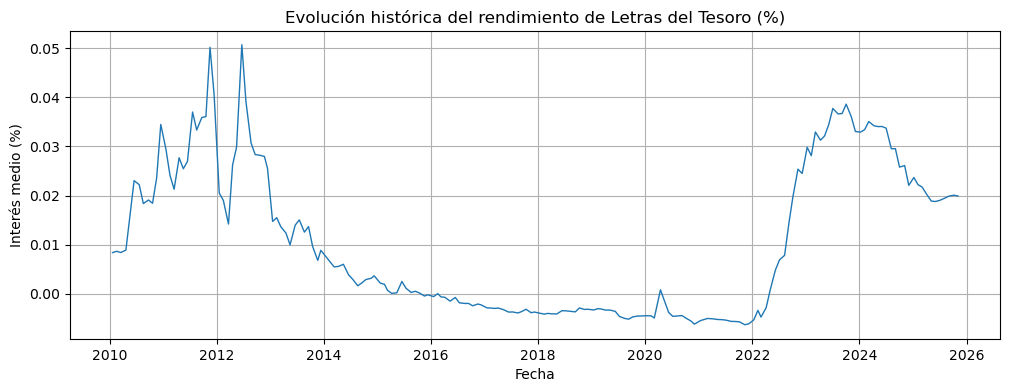

In [14]:
letras = letras.sort_values("fecha")

# Selección de serie temporal de interés medio
letras_yield = letras.set_index("fecha")["interes_medio"]

plt.figure(figsize=(12,4))
plt.plot(letras_yield.index, letras_yield.values, linewidth=1)
plt.title("Evolución histórica del rendimiento de Letras del Tesoro (%)")
plt.xlabel("Fecha")
plt.ylabel("Interés medio (%)")
plt.grid(True)
plt.show()


## Volatilidad

In [15]:
btc["ret"] = btc["close"].pct_change()

# Volatilidad diaria
vol_btc = btc["ret"].std()

# Volatilidad anualizada simple
vol_anual_btc = vol_btc * (365 ** 0.5)


print("Volatilidad diaria Bitcoin:", vol_btc)
print("Volatilidad anualizada:", vol_anual_btc)

Volatilidad diaria Bitcoin: 0.09572172936701905
Volatilidad anualizada: 1.8287610717777445


In [16]:

oro["ret"] = oro["close_oz"].pct_change()

# Volatilidad diaria
vol_oro = oro["ret"].std()

# Volatilidad anualizada simple
vol_anual_oro = vol_oro * (365 ** 0.5)


print("Volatilidad diaria Oro:", vol_oro)
print("Volatilidad anualizada:", vol_anual_oro)

Volatilidad diaria Oro: 0.043473719363097275
Volatilidad anualizada: 0.8305642422295753


In [17]:
sp500["ret"] = sp500["close"].pct_change()
vol_diaria_sp500 = sp500["ret"].std()
vol_anual_sp500 = vol_diaria_sp500 * (365 ** 0.5)

print("SP500")
print("Volatilidad diaria:", vol_diaria_sp500)
print("Volatilidad anualizada:", vol_anual_sp500)

SP500
Volatilidad diaria: 0.025082252690208667
Volatilidad anualizada: 0.47919576480354054


In [18]:
# Calcular los retornos diarios
letras["ret"] = letras["nominal_adjudicado"].pct_change()

# Volatilidad diaria
vol_diaria_letras = letras["ret"].std()

# Volatilidad anualizada (√365)
vol_anual_letras = vol_diaria_letras * (365 ** 0.5)

# Mostrar resultados
print("Letras del Tesoro")
print("Volatilidad diaria:", vol_diaria_letras)
print("Volatilidad anualizada:", vol_anual_letras)


Letras del Tesoro
Volatilidad diaria: 0.20939784719737106
Volatilidad anualizada: 4.000540253512786


## Simulación 100€ mensuales 

en BTC

In [19]:
btc = btc.sort_values("open_time")

# Resample mensual usando el precio 'close'
btc_mensual = btc.set_index("open_time")["close"].resample("M").last()

# Inicializar variables
inversion_mensual = 100
btc_valor = []
btc_total_invertido = 0
btc_acumulado = 0

for precio in btc_mensual:
    btc_total_invertido += inversion_mensual
    btc_acumulado += inversion_mensual / precio  
    btc_valor.append(btc_acumulado * precio)  


btc_dca = pd.DataFrame({
    "Fecha": btc_mensual.index,
    "Valor acumulado": btc_valor,
    "Invertido acumulado": [inversion_mensual*(i+1) for i in range(len(btc_mensual))]
})


print(btc_dca.head())
print(btc_dca.tail())


total_invertido = btc_dca["Invertido acumulado"].iloc[-1]
valor_final = btc_dca["Valor acumulado"].iloc[-1]
ganancia = valor_final - total_invertido
print("-----------------")
print("Total invertido:", total_invertido, "€")
print("Valor final de la inversión:", valor_final, "€")
print("Ganancia/pérdida:", ganancia, "€")


       Fecha  Valor acumulado  Invertido acumulado
0 2017-08-31       100.000000                  100
1 2017-09-30       197.103622                  200
2 2017-10-31       430.646269                  300
3 2017-11-30       754.640655                  400
4 2017-12-31      1027.052647                  500
         Fecha  Valor acumulado  Invertido acumulado
96  2025-08-31     76034.127390                 9700
97  2025-09-30     86836.131878                 9800
98  2025-10-31     77835.224312                 9900
99  2025-11-30     63725.362797                10000
100 2025-12-31     66005.516347                10100
-----------------
Total invertido: 10100 €
Valor final de la inversión: 66005.51634682434 €
Ganancia/pérdida: 55905.51634682434 €


/var/folders/jv/lpcmj8m91yggsl2fvg3tnx2w0000gn/T/ipykernel_88631/3742110757.py:4: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



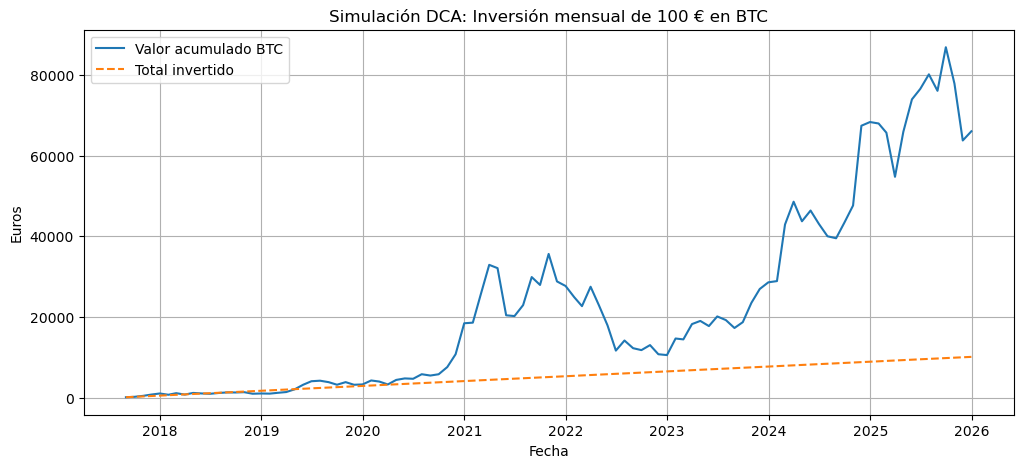

In [20]:
# --- Gráfico ---
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5))
plt.plot(btc_dca["Fecha"], btc_dca["Valor acumulado"], label="Valor acumulado BTC")
plt.plot(btc_dca["Fecha"], btc_dca["Invertido acumulado"], label="Total invertido", linestyle="--")
plt.title("Simulación DCA: Inversión mensual de 100 € en BTC")
plt.xlabel("Fecha")
plt.ylabel("Euros")
plt.legend()
plt.grid(True)
plt.show()

### 100€ mensuales en ORO

In [21]:

oro_2015 = oro[oro["open_time"] >= "2015-01-01"]

oro_mensual = oro_2015.set_index("open_time")["high_oz"].resample("M").last().ffill()


inversion_mensual = 100
oro_valor = []
oro_acumulado = 0


for precio in oro_mensual:
    oro_acumulado += inversion_mensual / precio
    oro_valor.append(oro_acumulado * precio)


oro_dca = pd.DataFrame({
    "Fecha": oro_mensual.index,
    "Valor acumulado": oro_valor,
    "Invertido acumulado": [inversion_mensual*(i+1) for i in range(len(oro_mensual))]
})

total_invertido = oro_dca["Invertido acumulado"].iloc[-1]
valor_final = oro_dca["Valor acumulado"].iloc[-1]
ganancia = valor_final - total_invertido

print(oro_dca.head())
print(oro_dca.tail())
print("-----------------")
print("Total invertido:", total_invertido, "€")
print("Valor final de la inversión:", valor_final, "€")
print("Ganancia/pérdida:", ganancia, "€")



       Fecha  Valor acumulado  Invertido acumulado
0 2015-01-31       100.000000                  100
1 2015-02-28       196.483913                  200
2 2015-03-31       295.566864                  300
3 2015-04-30       401.147624                  400
4 2015-05-31       487.090558                  500
         Fecha  Valor acumulado  Invertido acumulado
126 2025-07-31     25813.303945                12700
127 2025-08-31     27428.765205                12800
128 2025-09-30     31029.608225                12900
129 2025-10-31     33475.424048                13000
130 2025-11-30     32582.576010                13100
-----------------
Total invertido: 13100 €
Valor final de la inversión: 32582.57601012174 €
Ganancia/pérdida: 19482.57601012174 €


/var/folders/jv/lpcmj8m91yggsl2fvg3tnx2w0000gn/T/ipykernel_88631/3331804744.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



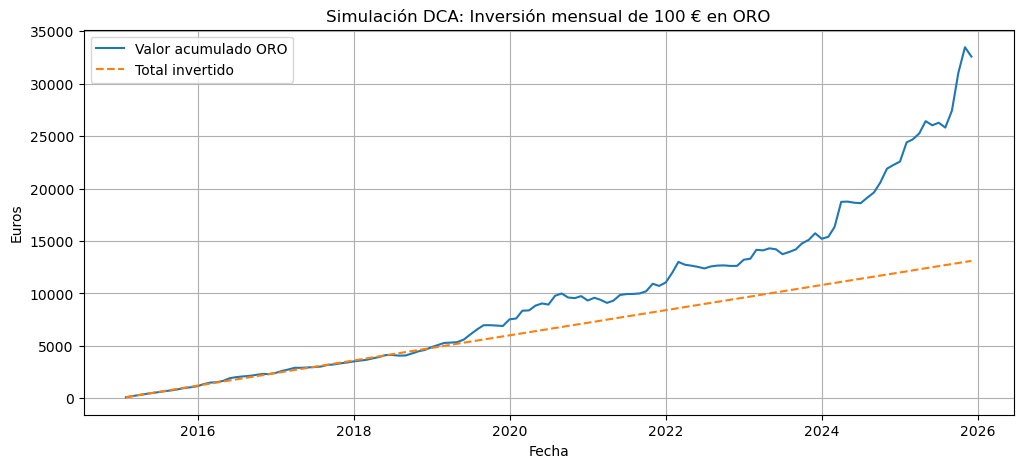

In [22]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(oro_dca["Fecha"], oro_dca["Valor acumulado"], label="Valor acumulado ORO")
plt.plot(oro_dca["Fecha"], oro_dca["Invertido acumulado"], label="Total invertido", linestyle="--")
plt.title("Simulación DCA: Inversión mensual de 100 € en ORO")
plt.xlabel("Fecha")
plt.ylabel("Euros")
plt.legend()
plt.grid(True)
plt.show()


### 100€ mensuales en SP&500

In [23]:
sp500_2015 = sp500[sp500["open_time"] >= "2015-01-01"]

sp500_mensual = sp500_2015.set_index("open_time")["high"].resample("M").last().ffill()

inversion_mensual = 100
sp500_valor = []
sp500_acumulado = 0


for precio in sp500_mensual:
    sp500_acumulado += inversion_mensual / precio
    sp500_valor.append(sp500_acumulado * precio)


sp500_dca = pd.DataFrame({
    "Fecha": sp500_mensual.index,
    "Valor acumulado": sp500_valor,
    "Invertido acumulado": [inversion_mensual*(i+1) for i in range(len(sp500_mensual))]
})


total_invertido = sp500_dca["Invertido acumulado"].iloc[-1]
valor_final = sp500_dca["Valor acumulado"].iloc[-1]
ganancia = valor_final - total_invertido

print(sp500_dca.head())
print(sp500_dca.tail())
print("-----------------")
print("Total invertido:", total_invertido, "€")
print("Valor final de la inversión:", valor_final, "€")
print("Ganancia/pérdida:", ganancia, "€")


       Fecha  Valor acumulado  Invertido acumulado
0 2015-01-31       100.000000                  100
1 2015-02-28       203.013219                  200
2 2015-03-31       300.082381                  300
3 2015-04-30       405.383023                  400
4 2015-05-31       504.620272                  500
         Fecha  Valor acumulado  Invertido acumulado
126 2025-07-31     25755.779636                12700
127 2025-08-31     26279.083594                12800
128 2025-09-30     27256.923617                12900
129 2025-10-31     28041.165921                13000
130 2025-11-30     27312.168771                13100
-----------------
Total invertido: 13100 €
Valor final de la inversión: 27312.168771207154 €
Ganancia/pérdida: 14212.168771207154 €


/var/folders/jv/lpcmj8m91yggsl2fvg3tnx2w0000gn/T/ipykernel_88631/3541965299.py:3: FutureWarning:

'M' is deprecated and will be removed in a future version, please use 'ME' instead.



In [24]:
import plotly.express as px

fig = px.line(
    sp500_dca,
    x="Fecha",
    y=["Valor acumulado", "Invertido acumulado"],
    title="Simulación DCA: Inversión mensual de 100 € en S&P 500",
    labels={"value": "Euros", "Fecha": "Fecha", "variable": "Serie"}
)

fig.update_layout(
    legend_title_text="",
    hovermode="x unified"
)

fig.show()

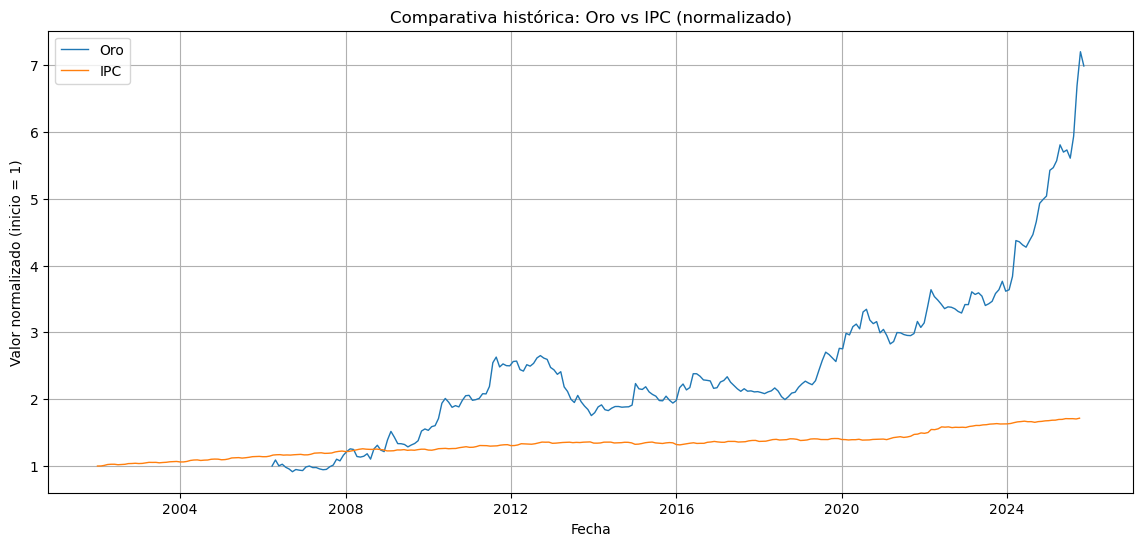

In [25]:
import matplotlib.pyplot as plt

# --- Asegurarse de que las fechas estén en datetime ---
oro["open_time"] = pd.to_datetime(oro["open_time"], format="%d-%b-%Y")
ipc["Fecha"] = pd.to_datetime(ipc["Periodo"], format="%YM%m")

# --- Ordenar por fecha ---
oro = oro.sort_values("open_time")
ipc = ipc.sort_values("Fecha")

# --- Normalizar los valores para compararlos ---
oro_norm = oro["high_oz"] / oro["high_oz"].iloc[0]
ipc_norm = ipc["Total"] / ipc["Total"].iloc[0]

# --- Gráfico comparativo ---
plt.figure(figsize=(14,6))
plt.plot(oro["open_time"], oro_norm, label="Oro", linewidth=1)
plt.plot(ipc["Fecha"], ipc_norm, label="IPC", linewidth=1)
plt.title("Comparativa histórica: Oro vs IPC (normalizado)")
plt.xlabel("Fecha")
plt.ylabel("Valor normalizado (inicio = 1)")
plt.legend()
plt.grid(True)
plt.show()


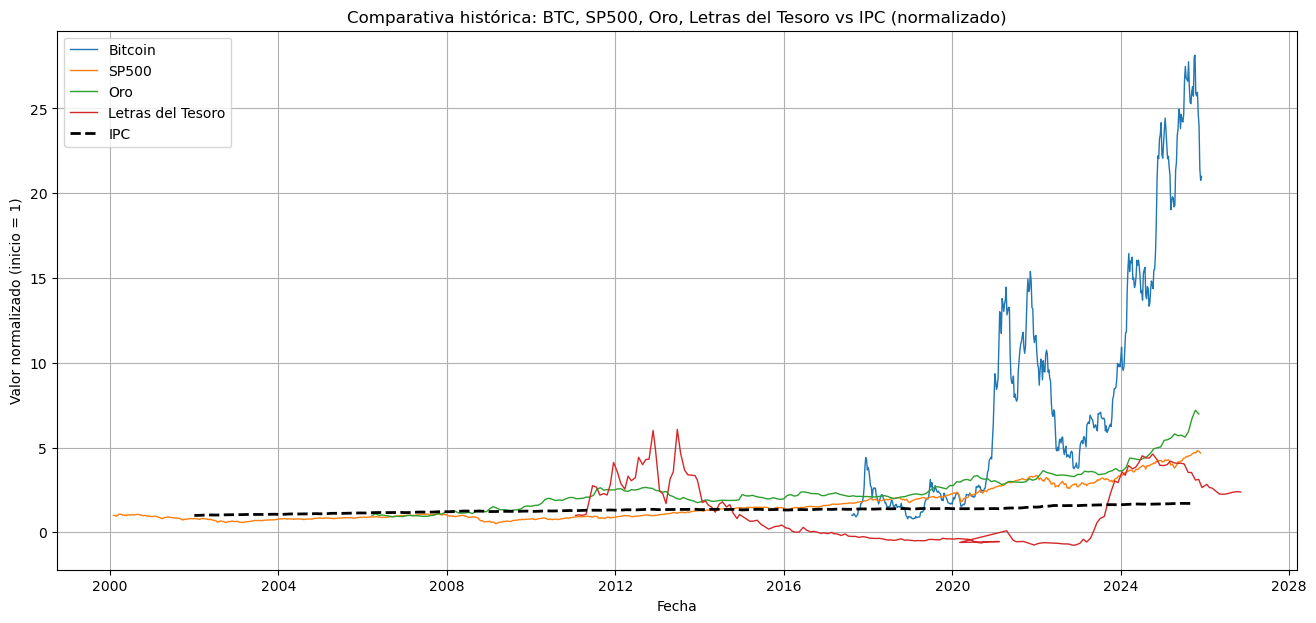

In [26]:

# --- Ordenar por fecha ---
btc = btc.sort_values("open_time")
sp500 = sp500.sort_values("open_time")
oro = oro.sort_values("open_time")
letras = letras.sort_values("fecha")
ipc = ipc.sort_values("Periodo")

# --- Normalizar valores ---
btc_norm = btc["high"].astype(float) / float(btc["high"].iloc[0])
sp500_norm = sp500["high"].astype(float) / float(sp500["high"].iloc[0])
oro_norm = oro["high_oz"].astype(float) / float(oro["high_oz"].iloc[0])
letras_norm = letras["interes_medio"].astype(float) / float(letras["interes_medio"].iloc[0])
ipc_norm = ipc["Total"].astype(float) / float(ipc["Total"].iloc[0])

# --- Gráfico comparativo ---
plt.figure(figsize=(16,7))
plt.plot(btc["open_time"], btc_norm, label="Bitcoin", linewidth=1)
plt.plot(sp500["open_time"], sp500_norm, label="SP500", linewidth=1)
plt.plot(oro["open_time"], oro_norm, label="Oro", linewidth=1)
plt.plot(letras["fecha_vencimiento"], letras_norm, label="Letras del Tesoro", linewidth=1)
plt.plot(ipc["Periodo"], ipc_norm, label="IPC", linewidth=2, color="black", linestyle="--")

plt.title("Comparativa histórica: BTC, SP500, Oro, Letras del Tesoro vs IPC (normalizado)")
plt.xlabel("Fecha")
plt.ylabel("Valor normalizado (inicio = 1)")
plt.legend()
plt.grid(True)
plt.show()


### Ratio de Sharpe

El ratio de Sharpe es un indicador que mide la rentabilidad ajustada al riesgo de una inversión. En otras palabras, te dice cuánto rendimiento obtienes por cada unidad de riesgo que asumes.

Sharpe= (Rendimiento del activo - Tasa libre de riesgo) / Volatilidad del activo

In [27]:
#Rendimiento de los activos (Variación respecto al anterior dato)
btc['ret'] = btc['high'].pct_change()
sp500['ret'] = sp500['high'].pct_change()
oro['ret'] = oro['high_oz'].pct_change()
letras['ret'] = letras['interes_medio'].pct_change()

In [28]:
rf = 0  # Tasa tipo de riesgo

#365 días, porque opera todos los días
sharpe_btc = ((btc['ret'].mean() - rf) / btc['ret'].std()) * (365**0.5)

#(252 días hábiles)
sharpe_sp500 = ((sp500['ret'].mean() - rf) / sp500['ret'].std()) * (252**0.5)

#(252 días hábiles)
sharpe_oro = ((oro['ret'].mean() - rf) / oro['ret'].std()) * (252**0.5)

print("Sharpe BTC:", sharpe_btc)
print("Sharpe SP500:", sharpe_sp500)
print("Sharpe Oro:", sharpe_oro)


Sharpe BTC: 2.360823095285066
Sharpe SP500: 1.182446559680704
Sharpe Oro: 3.3646452579895305


Sharpe BTC ≈ 2.33 → Bitcoin ha tenido mucha volatilidad, pero sus retornos han sido altos comparados con su riesgo.

Sharpe SP500 ≈ 1.18 → El S&P 500 es más estable que BTC, pero también ofrece retornos más moderados respecto a su riesgo.

Sharpe Oro ≈ 3.36 → El oro ha sido muy estable en comparación con sus retornos, por eso el ratio es alto; poca volatilidad relativa.

In [29]:
oro.to_csv("datos limpios/oro_limpio.csv", index=False)
btc.to_csv("datos limpios/btc_limpio.csv", index=False)
sp500.to_csv("datos limpios/sp500_limpio.csv", index=False)
letras.to_csv("datos limpios/letras_limpias.csv", index=False)
ipc.to_csv("datos limpios/ipc_limpio.csv", index=False)

In [30]:
sp500 = pd.read_csv("datos limpios/sp500_limpio.csv")
btc = pd.read_csv("datos limpios/btc_limpio.csv")
oro = pd.read_csv("datos limpios/oro_limpio.csv")

for df in [sp500, btc, oro]:
    df["open_time"] = pd.to_datetime(df["open_time"])
    df.sort_values("open_time", inplace=True)
    df.set_index("open_time", inplace=True)

def rendimiento_anual(df, precio_col):
    precios_mensuales = df[precio_col].resample("ME").last()
    retornos = precios_mensuales.pct_change(fill_method=None).dropna()
    retorno_medio_mensual = retornos.mean()
    retorno_anual = (1 + retorno_medio_mensual)**12 - 1
    return retorno_anual

rendimiento_sp500 = rendimiento_anual(sp500, precio_col="high")
rendimiento_btc = rendimiento_anual(btc, precio_col="high")
rendimiento_oro = rendimiento_anual(oro, precio_col="high_oz")

print(f"Rendimiento anual historico del SP&500: {rendimiento_sp500:.2%}")
print(f"Rendimiento anual historico del Bitcoin: {rendimiento_btc:.2%}")
print(f"Rendimiento anual historico del Oro: {rendimiento_oro:.2%}")


Rendimiento anual historico del SP&500: 7.21%
Rendimiento anual historico del Bitcoin: 84.12%
Rendimiento anual historico del Oro: 11.64%


###  MACHINE LEARNING 

In [31]:
import pandas as pd
import numpy as np
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score, classification_report

df = pd.read_csv("datos limpios/sp500_limpio.csv")
df["open_time"] = pd.to_datetime(df["open_time"])
df = df.sort_values("open_time")

df["ret"] = df["close"].pct_change()

df["ret_1d"] = df["ret"].shift(1)
df["ret_5d"] = df["close"].pct_change(5)
df["ret_20d"] = df["close"].pct_change(20)

df["sma_10"] = df["close"].rolling(10).mean()
df["sma_20"] = df["close"].rolling(20).mean()
df["sma_50"] = df["close"].rolling(50).mean()
df["sma_200"] = df["close"].rolling(200).mean()

df["sma_10_ratio"] = df["sma_10"] / df["close"]
df["sma_20_ratio"] = df["sma_20"] / df["close"]
df["sma_50_ratio"] = df["sma_50"] / df["close"]
df["sma_200_ratio"] = df["sma_200"] / df["close"]

df["vol_10"] = df["ret"].rolling(10).std()
df["vol_20"] = df["ret"].rolling(20).std()

df["target"] = (df["ret"].shift(-1) > 0).astype(int)

df = df.dropna()

X = df[[
    "ret_1d","ret_5d","ret_20d",
    "sma_10_ratio","sma_20_ratio","sma_50_ratio","sma_200_ratio",
    "vol_10","vol_20"
]]
y = df["target"]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

model = XGBClassifier(
    n_estimators=300,
    learning_rate=0.03,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8
)

model.fit(X_train, y_train)

pred = model.predict(X_test)
probs = model.predict_proba(X_test)[:,1]

print("Accuracy:", accuracy_score(y_test, pred))
print("AUC:", roc_auc_score(y_test, probs))
print(classification_report(y_test, pred))


Accuracy: 0.5217391304347826
AUC: 0.5352564102564102
              precision    recall  f1-score   support

           0       0.46      0.34      0.39       104
           1       0.55      0.67      0.61       126

    accuracy                           0.52       230
   macro avg       0.51      0.51      0.50       230
weighted avg       0.51      0.52      0.51       230



El modelo no tiene capacidad predictiva real. Concretamente:

Accuracy ≈ 0.52, prácticamente tirar una moneda.

AUC ≈ 0.53, muy por debajo del mínimo razonable (0.60–0.70).

Precision/Recall/F1 mediocres para ambas clases.

El modelo no está aprendiendo patrones útiles y el dataset no contiene señal suficiente para predecir si el S&P 500 subirá el mes siguiente basándose solo en sus precios pasados.

Esto es normal. Los retornos financieros son casi ruido blanco a corto/medio plazo.

Para predicciones futuras, usaremos las media anual de variación de cada activo.

In [32]:
letras

,fecha,nominal_solicitado,nominal_adjudicado,tipo_marginal,interes_medio,fecha_vencimiento,ret
190,2010-01-19,8305.02,4500.00,0.00858,0.00836,2011-01-21,NaN
189,2010-02-16,5860.27,3989.22,0.00897,0.00863,2011-02-18,0.032297
188,2010-03-16,8023.22,4692.22,0.00848,0.00838,2011-03-18,-0.028969
187,2010-04-20,7071.29,4715.26,0.00904,0.00887,2011-04-21,0.058473
186,2010-05-18,5499.23,4359.21,0.01699,0.01590,2011-05-20,0.792559
...,...,...,...,...,...,...,...
4,2025-07-01,7006.25,4087.00,0.01914,0.01900,2026-07-10,0.011715
3,2025-08-05,5116.77,4032.75,0.01958,0.01945,2026-08-07,0.023684
2,2025-09-02,6497.36,4174.20,0.01996,0.01986,2026-09-04,0.021080
1,2025-10-07,6048.46,3820.10,0.02021,0.02006,2026-10-09,0.010070
